# **Temur** **12200338**

In this analysis, we explore a dataset containing information on various transactions, including 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Total', 'Date', 'Time', 'Payment', and 'Gross income'. Our primary goal is to predict the 'Rating' variable, which represents customer satisfaction with their shopping experience.

To achieve this goal, we will perform feature extraction, preprocessing, and model selection. We will experiment with several regression models, including Linear Regression, Decision Tree, Random Forest, Support Vector Regression (SVR), K-Nearest Neighbors (KNN), and Neural Network (MLPRegressor), to identify the most suitable model for predicting customer ratings. We will evaluate the performance of these models using the R2 score, which measures the proportion of the variance in the dependent variable that is predictable from the independent variables.

By conducting this analysis, we aim to provide valuable insights that can help supermarket-sales improve their customer satisfaction levels and ultimately drive better business outcomes.

Import liabraries and loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
data = pd.read_csv('supermarket_sales.csv')

In [4]:
data.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

In [5]:
data.isnull().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [6]:
print(data.describe())

        Unit price     Quantity       Tax 5%        Total        cogs  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.00000   
mean     55.672130     5.510000    15.379369   322.966749   307.58738   
std      26.494628     2.923431    11.708825   245.885335   234.17651   
min      10.080000     1.000000     0.508500    10.678500    10.17000   
25%      32.875000     3.000000     5.924875   124.422375   118.49750   
50%      55.230000     5.000000    12.088000   253.848000   241.76000   
75%      77.935000     8.000000    22.445250   471.350250   448.90500   
max      99.960000    10.000000    49.650000  1042.650000   993.00000   

       gross margin percentage  gross income      Rating  
count              1000.000000   1000.000000  1000.00000  
mean                  4.761905     15.379369     6.97270  
std                   0.000000     11.708825     1.71858  
min                   4.761905      0.508500     4.00000  
25%                   4.761905      5.924875   

Unit price: mu = 55.67, sigma = 26.48
Unit price: Skewness: 0.01
Unit price: Kurtosis: -1.22


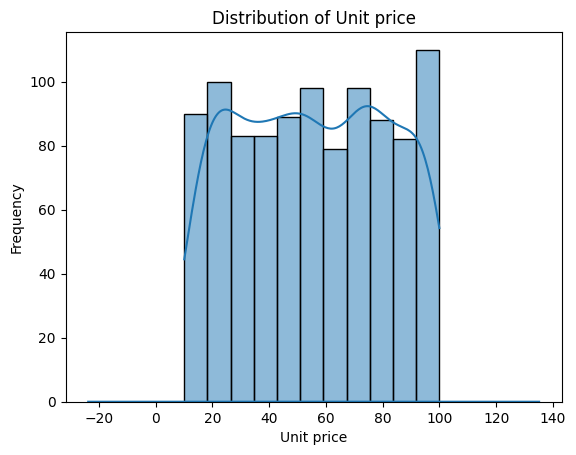

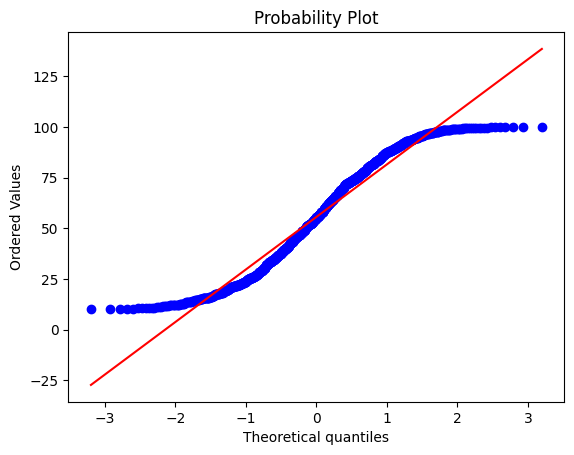

Total: mu = 322.97, sigma = 245.76
Total: Skewness: 0.89
Total: Kurtosis: -0.08


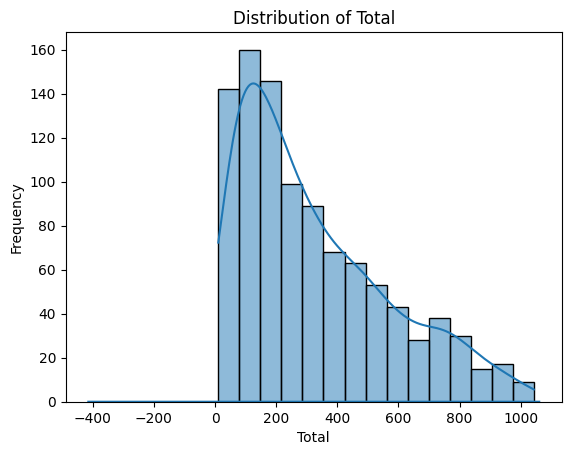

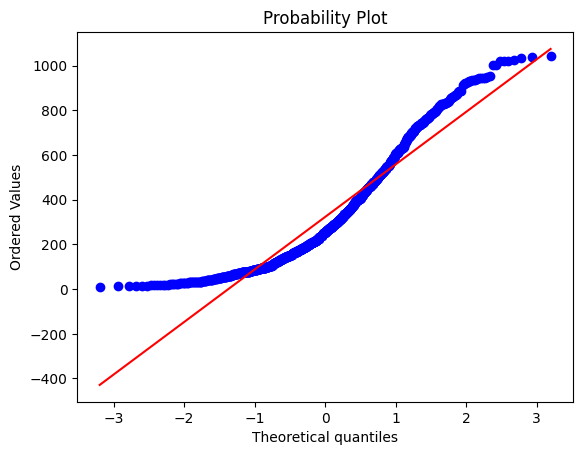

Rating: mu = 6.97, sigma = 1.72
Rating: Skewness: 0.01
Rating: Kurtosis: -1.15


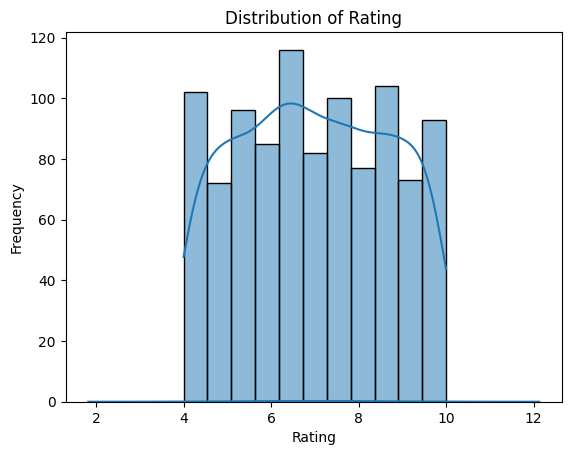

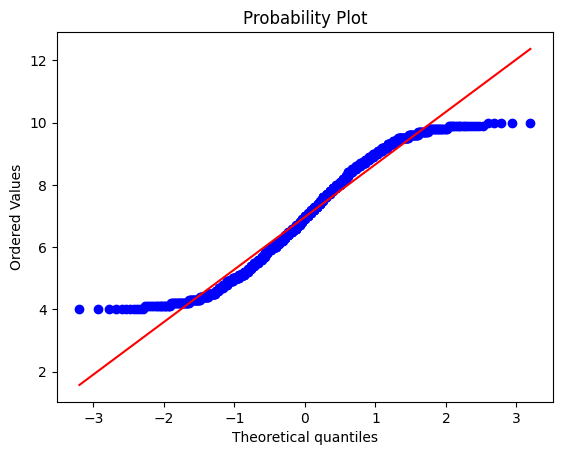

gross income: mu = 15.38, sigma = 11.70
gross income: Skewness: 0.89
gross income: Kurtosis: -0.08


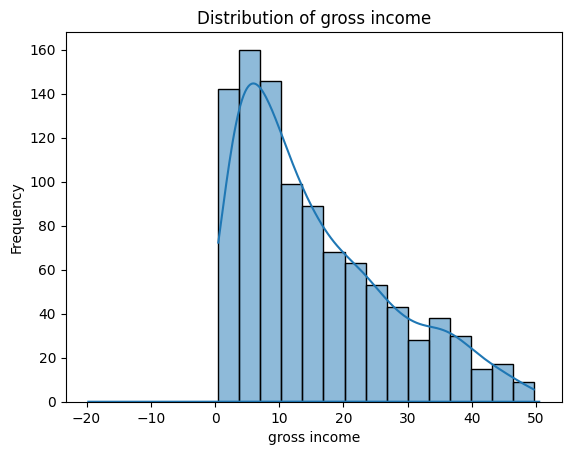

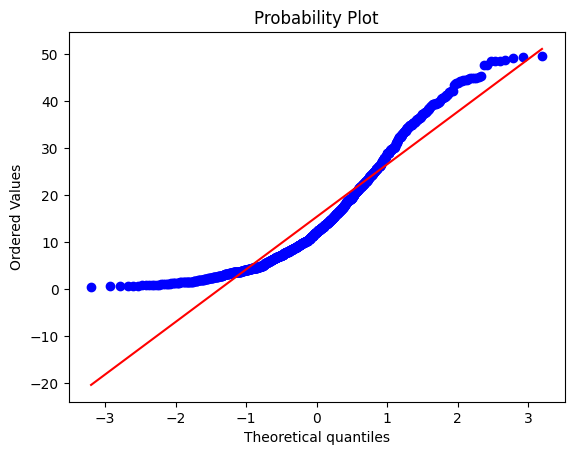

In [7]:
# Create a list of the columns to analyze
columns = ['Unit price', 'Total', 'Rating', 'gross income']

# Loop over the columns and plot the distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sns.histplot(data[col], kde=True)

    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculate the skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, data[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, data[col].kurt()))

    # Add the fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(data[col], plot=plt)

    plt.show()

In [8]:
#Convert the 'Time' column to a datetime object and filter the data to only include store open hours:
data['Time'] = pd.to_datetime(data['Time'])
data = data[(data['Time'].dt.hour >= 10) & (data['Time'].dt.hour < 21)]

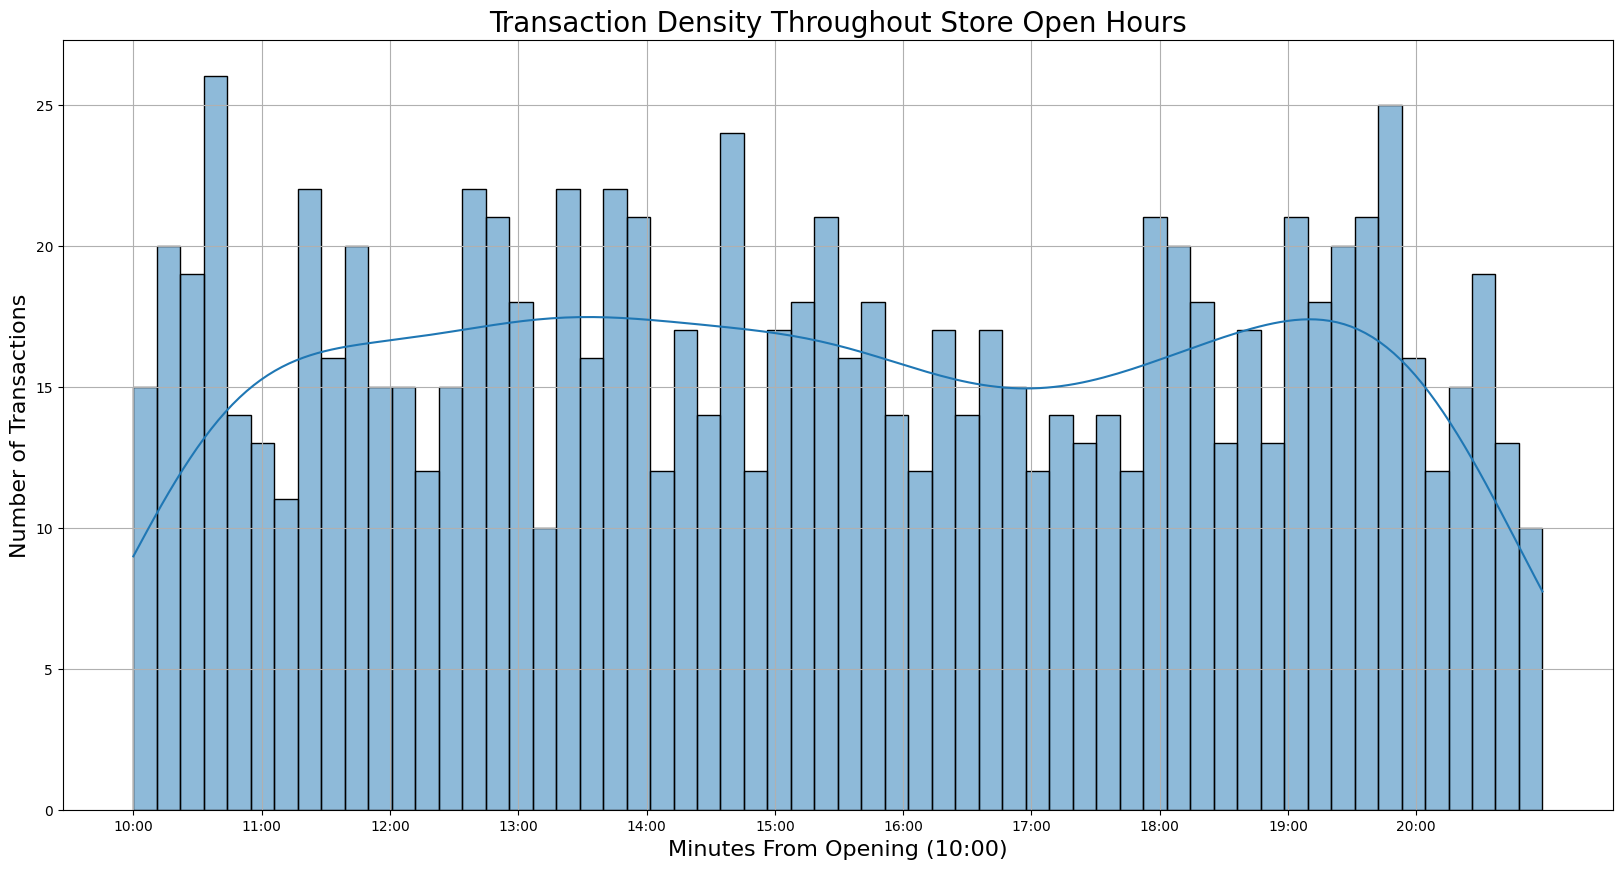

In [9]:
#Convert 'Time' to minutes from store opening:
data['MinutesFromOpening'] = (data['Time'].dt.hour - 10) * 60 + data['Time'].dt.minute
#Create a distribution plot to visualize the transaction density:
plt.figure(figsize=(20, 10))
sns.histplot(data=data, x='MinutesFromOpening', bins=60, kde=True)
plt.title('Transaction Density Throughout Store Open Hours', fontsize=20)
plt.xlabel('Minutes From Opening (10:00)', fontsize=16)
plt.ylabel('Number of Transactions', fontsize=16)
plt.xticks(np.arange(0, 660, 60), [f"{10 + t // 60:02d}:{t % 60:02d}" for t in np.arange(0, 660, 60)])
plt.grid(True)
plt.show()

The transaction density plot shows the distribution of transaction density over the course of the day (from 10.00-21.00), with a peak in transaction density occurring shortly after the store opening and a decrease in density as the day progresses. This information can be useful for understanding the store's traffic patterns and making decisions about staffing and inventory management.

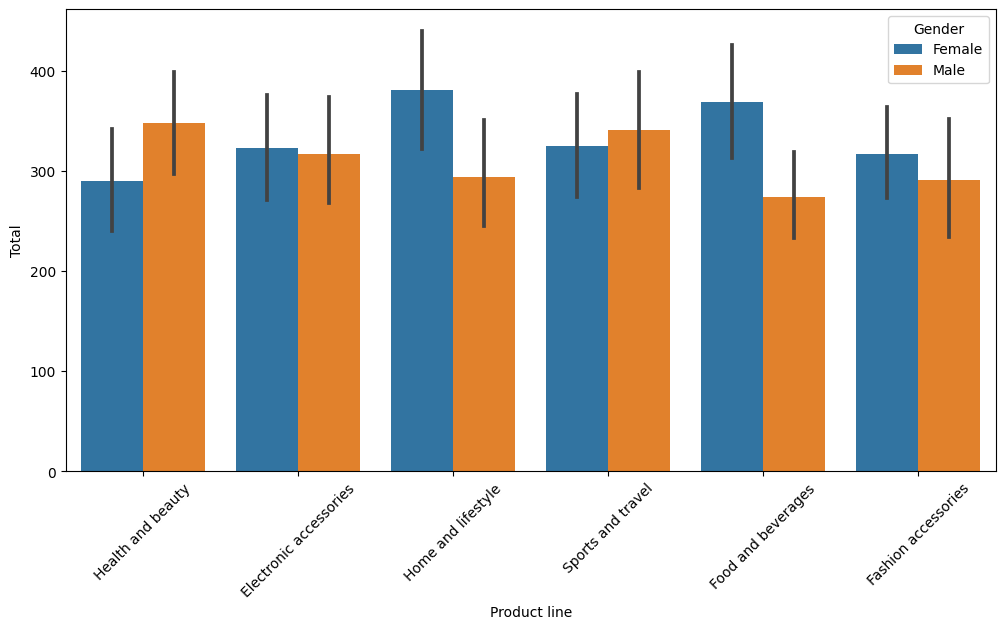

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Product line', y='Total', hue='Gender', data=data)
plt.xticks(rotation=45)
plt.show()

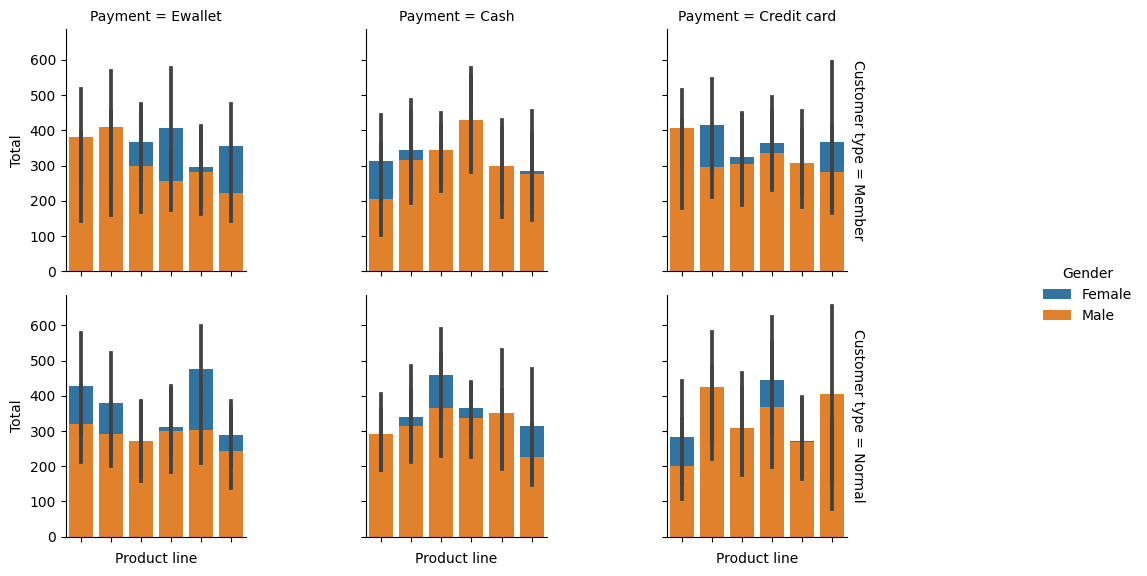

In [11]:
g = sns.FacetGrid(data, col='Payment', row='Customer type', hue='Gender', margin_titles=True)
g.map(sns.barplot, 'Product line', 'Total')

# Set custom legend properties
g.add_legend(title='Gender', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Improve the readability of the 'Product line' labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.show()

The resulting plot shows a series of bar charts, each one corresponding to a combination of 'Payment', 'Customer type', and 'Gender'. The bar charts show the total sales for each product line, and the colors of the bars indicate the gender of the customers. This plot allows us to quickly identify any patterns or trends in sales based on the different categories, and can be useful for making informed decisions about marketing, inventory management, and staffing.

In [12]:
# Resample the data to show weekly total sales
data['Date'] = pd.to_datetime(data['Date'])
weekly_data = data.groupby(['City', pd.Grouper(key='Date', freq='W')])['Total'].sum().reset_index()

In [13]:
mean_total_sales = weekly_data.groupby('Date')['Total'].mean().reset_index()
mean_total_sales.rename(columns={'Total': 'Mean Total Sales'}, inplace=True)

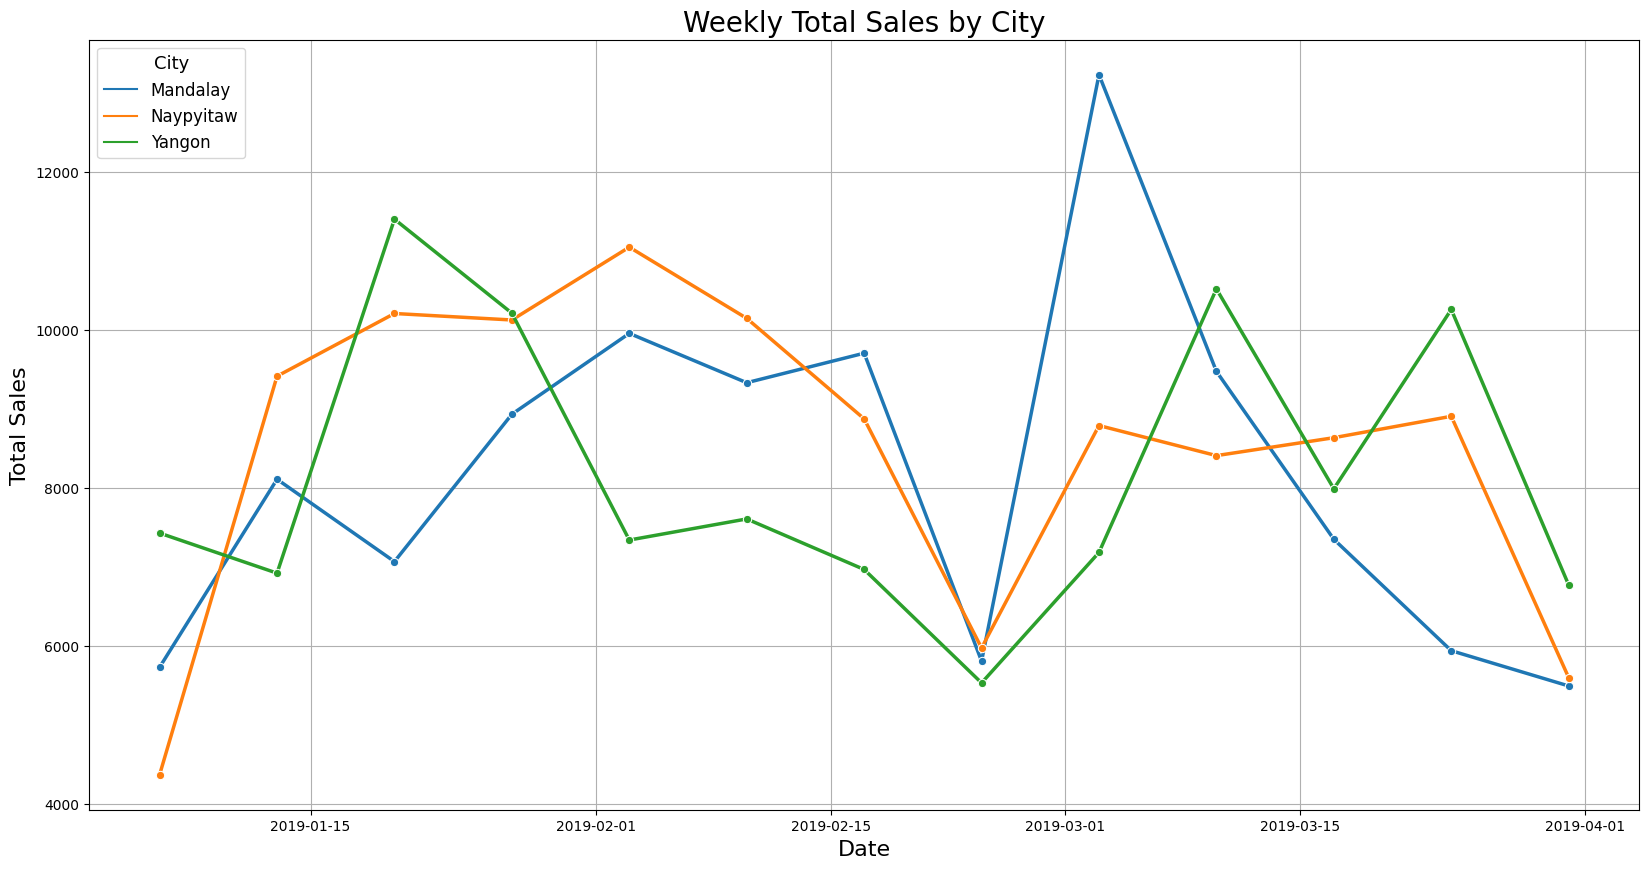

In [14]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='Date', y='Total', hue='City', data=weekly_data, marker='o', linewidth=2.5)
plt.title('Weekly Total Sales by City', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Sales', fontsize=16)
plt.grid(True)
plt.legend(title='City', title_fontsize='13', loc='upper left', fontsize='12')
plt.show()

Weekly Total Sales plot help us identify any trends or patterns in the sales data. For example, if we see an increasing trend in sales over time for a particular city, we may want to investigate why this is happening and try to capitalize on it. Conversely, if we see a decreasing trend in sales over time, we may want to investigate what is causing this and try to make changes to improve sale

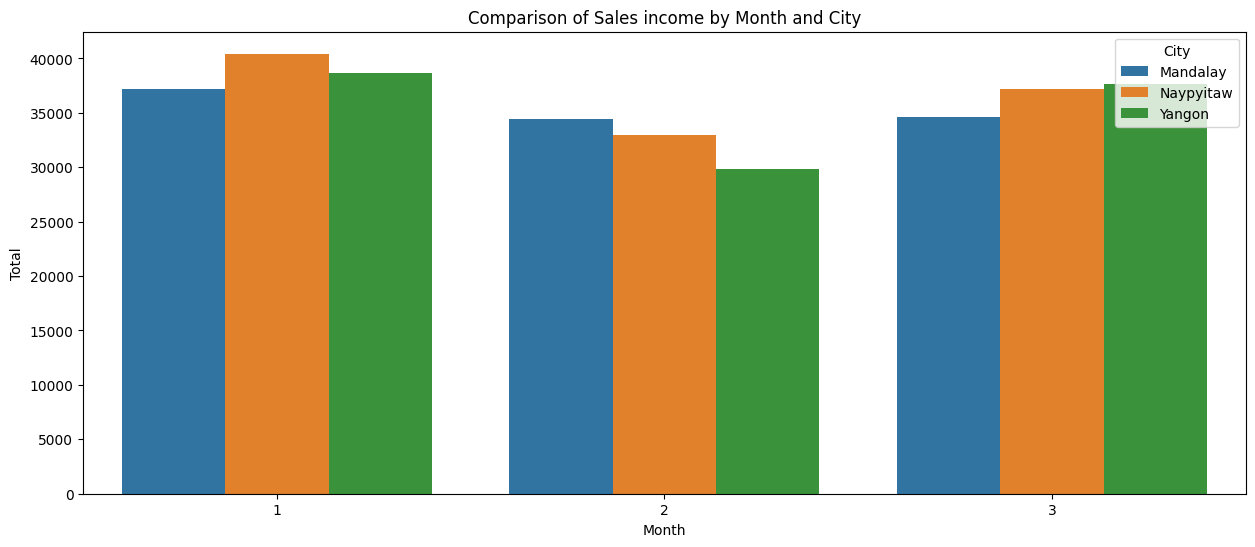

In [15]:
#Comparision of Sales between branch Plot
data['Month'] = data['Date'].dt.month
grouped_data = data.groupby(['City', 'Month'])['Total'].sum().reset_index()
# Visualize the comparison using a bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='Month', y='Total', hue='City', data=grouped_data)
plt.title('Comparison of Sales income by Month and City')
plt.xlabel('Month')
plt.ylabel('Total')
plt.legend(title='City', loc='upper right')
plt.show()

Making a Prediction
In our analysis, we aimed to predict the 'Rating' variable using the provided dataset containing features such as 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Total', 'Date', 'Time', 'Payment', and 'Gross income'. We extracted additional features from the 'Date' and 'Time' columns, performed one-hot encoding for categorical variables, and standardized the data before fitting various regression models.

In [16]:
data = pd.read_csv('supermarket_sales.csv')

In [18]:
# Convert 'Date' to a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Date features
data['day_of_week'] = data['Date'].dt.dayofweek
data['day_of_month'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

# Time features
data['Time'] = pd.to_datetime(data['Time'])
def map_time_interval(time):
    hour = time.hour
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

    # Apply the function to the 'Time' column
data['time_interval'] = data['Time'].apply(map_time_interval)

In [19]:
data

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,Payment,cogs,gross margin percentage,gross income,Rating,day_of_week,day_of_month,month,year,time_interval
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,...,Ewallet,522.83,4.761905,26.1415,9.1,5,5,1,2019,afternoon
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,...,Cash,76.40,4.761905,3.8200,9.6,4,8,3,2019,morning
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,...,Credit card,324.31,4.761905,16.2155,7.4,6,3,3,2019,afternoon
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,...,Ewallet,465.76,4.761905,23.2880,8.4,6,27,1,2019,evening
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,...,Ewallet,604.17,4.761905,30.2085,5.3,4,8,2,2019,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,...,Ewallet,40.35,4.761905,2.0175,6.2,1,29,1,2019,afternoon
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,...,Ewallet,973.80,4.761905,48.6900,4.4,5,2,3,2019,afternoon
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,...,Cash,31.84,4.761905,1.5920,7.7,5,9,2,2019,afternoon
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,...,Cash,65.82,4.761905,3.2910,4.1,4,22,2,2019,afternoon


In [20]:
for i in data.columns:
  if data[i].dtype=='object':
    print(data[i])

0      750-67-8428
1      226-31-3081
2      631-41-3108
3      123-19-1176
4      373-73-7910
          ...     
995    233-67-5758
996    303-96-2227
997    727-02-1313
998    347-56-2442
999    849-09-3807
Name: Invoice ID, Length: 1000, dtype: object
0      A
1      C
2      A
3      A
4      A
      ..
995    C
996    B
997    A
998    A
999    A
Name: Branch, Length: 1000, dtype: object
0         Yangon
1      Naypyitaw
2         Yangon
3         Yangon
4         Yangon
         ...    
995    Naypyitaw
996     Mandalay
997       Yangon
998       Yangon
999       Yangon
Name: City, Length: 1000, dtype: object
0      Member
1      Normal
2      Normal
3      Member
4      Normal
        ...  
995    Normal
996    Normal
997    Member
998    Normal
999    Member
Name: Customer type, Length: 1000, dtype: object
0      Female
1      Female
2        Male
3        Male
4        Male
        ...  
995      Male
996    Female
997      Male
998      Male
999    Female
Name: Gender, Length

In [21]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['City', 'Customer type', 'Gender', 'Product line', 'time_interval']

le = LabelEncoder()

for col in cat_cols:
    data[col] = le.fit_transform(data[col])

In [22]:
# Drop unnecessary columns
data.drop(['Invoice ID', 'Date', 'Time','Tax 5%','gross margin percentage','cogs','year'], axis=1, inplace=True)

In [23]:
# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns

In [24]:
for col in non_numeric_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [25]:
data.columns

Index(['Branch', 'City', 'Customer type', 'Gender', 'Product line',
       'Unit price', 'Quantity', 'Total', 'Payment', 'gross income', 'Rating',
       'day_of_week', 'day_of_month', 'month', 'time_interval'],
      dtype='object')

Rating           1.000000
City             0.049585
month            0.042880
gross income     0.036442
Total            0.036442
Product line     0.020529
Customer type    0.018889
Quantity         0.015815
day_of_week      0.013879
Branch           0.010238
time_interval    0.009876
Unit price       0.008778
day_of_month     0.007076
Payment          0.005381
Gender           0.004800
dtype: float64


<Axes: >

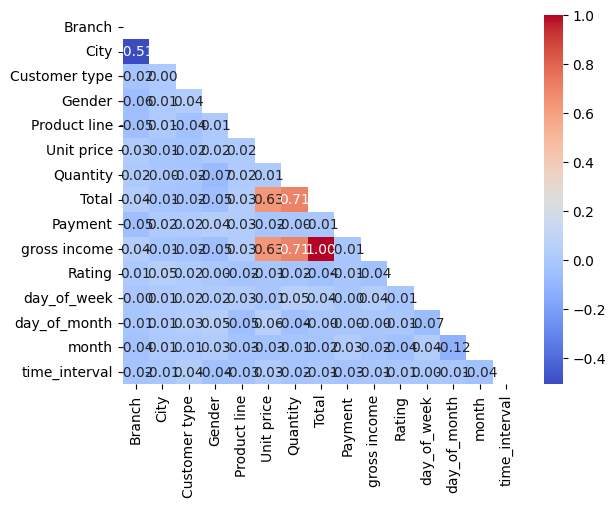

In [26]:
corr_matrix = data.corrwith(data['Rating'])

# Sort the correlation matrix by absolute values
corr_matrix = corr_matrix.abs().sort_values(ascending=False)

# Print the sorted correlation matrix
print(corr_matrix)

# Create a heatmap of the correlation matrix
corr_matrix = data.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f')

In [27]:
# Define target variable and features
X = data.drop('Rating', axis=1)
y = data['Rating']

In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The models used in our analysis include Linear Regression, Decision Tree, Random Forest, Support Vector Regression (SVR), K-Nearest Neighbors (KNN), and Neural Network (MLPRegressor). We evaluated the performance of these models using the R2 score.

In [30]:
# Model comparison
from sklearn.metrics import mean_absolute_error
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Neural Network": MLPRegressor(max_iter=1000)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = mean_absolute_error(y_test, y_pred)
    results[name] = r2
    print(f"{name}: {r2}")

Linear Regression: 1.5098541138038843
Decision Tree: 1.9633333333333334
Random Forest: 1.5353166666666667
SVR: 1.5792932235866084
KNN: 1.6221333333333332
Neural Network: 1.707440188389601


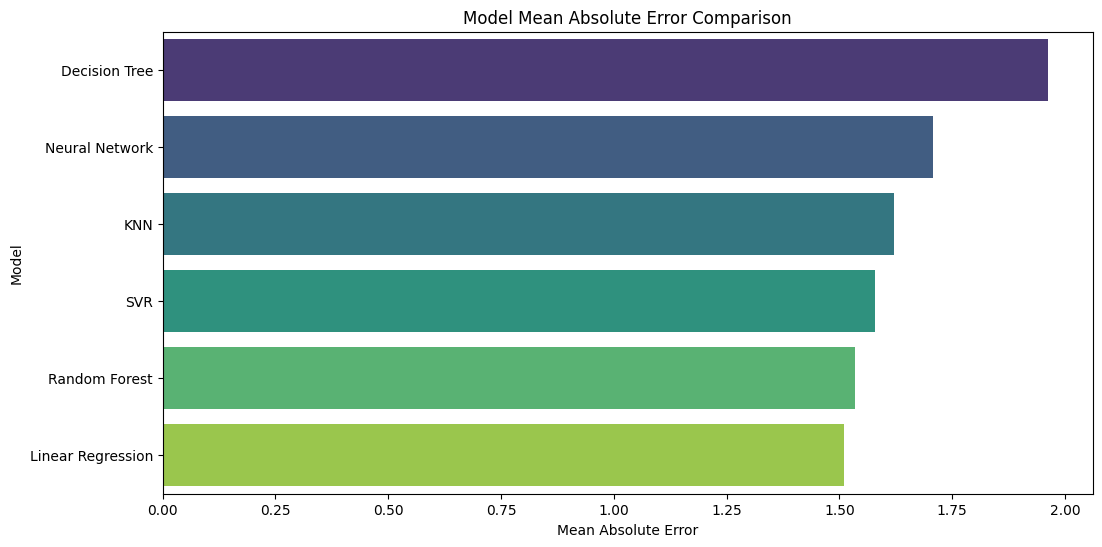

In [31]:
# Visualization
results_df = pd.DataFrame({"Model": list(results.keys()), "Mean Absolute Error": list(results.values())})
results_df = results_df.sort_values(by="Mean Absolute Error", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Mean Absolute Error", y="Model", palette="viridis")
plt.title("Model Mean Absolute Error Comparison")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Model")
plt.show()